<a href="https://colab.research.google.com/github/aseddin/F23_ECE4715/blob/main/2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

This notebook delves into classification, a supervised learning task focused on predicting a class based on input data. Additionally, it explores classification metrics for evaluating model performance, error analysis, and both multilabel and multioutput classification.

In [1]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## MNIST

The MNIST, which stands for the "Modified National Institute of Standards and Technology" database, is widely used dataset in machine learning. It has been studied so much and it is often used as the _hello world_ of machine learning. The dataset contains 28x28 pixel grayscale images of handwritten digits (0-9), with 70,000 images divided into training (60,000) and testing (10,000) sets.

### 1.Get the data

In [2]:
# fetch the dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
type(mnist)

sklearn.utils._bunch.Bunch

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The `Bunch` datatype is a modified dictionary whos keys can also be accessed as attributes.

In [5]:
mnist.DESCR == mnist['DESCR']

True

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
X, y = mnist.data, mnist.target

In [8]:
# 28*28 = 784
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

The dataset is already split into train/test sets

In [10]:
X_train = X[:60000]
y_train = y[:60000]

X_test = X[60000:]
y_test = y[60000:]

### 2.Look at the data to gain insights

In [11]:
X_train.dtype

dtype('int64')

In [12]:
X_train.max()

255

In [13]:
X_train.min()

0

In [14]:
np.unique(X_train)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [15]:
np.unique(y_train, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [16]:
def plot_digit(image_data, label=None):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")
  if label is not None:
    plt.title(label, fontsize=16)

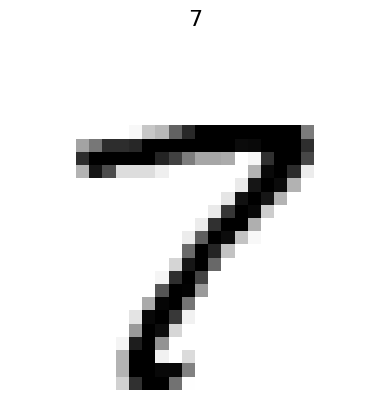

In [17]:
digit_index = 9990
some_digit = X_train[digit_index]
digit_class = y_train[digit_index]
plot_digit(some_digit, digit_class)
plt.show()

In [18]:
# you will get an error if the number of rows and the number of images are not
# divisible by each other
# this issue needs to be fixed when there is time
# Anyhow, the purpose of this function is to look at different images along with
# thier class labels or predictions

def plot_several_digits(images_data, rows, labels=None):
  image_count = len(images_data)
  columns = image_count // rows
  plt.figure(figsize=(9, 9))
  plt.subplots_adjust(wspace=0, hspace=0)

  if labels is not None:
    assert len(labels) == image_count
    for i in range(image_count):
      plt.subplot(rows, columns, i + 1)
      plot_digit(images_data[i], labels[i])
  else:
    for i in range(image_count):
      plt.subplot(rows, columns, i + 1)
      plot_digit(images_data[i])

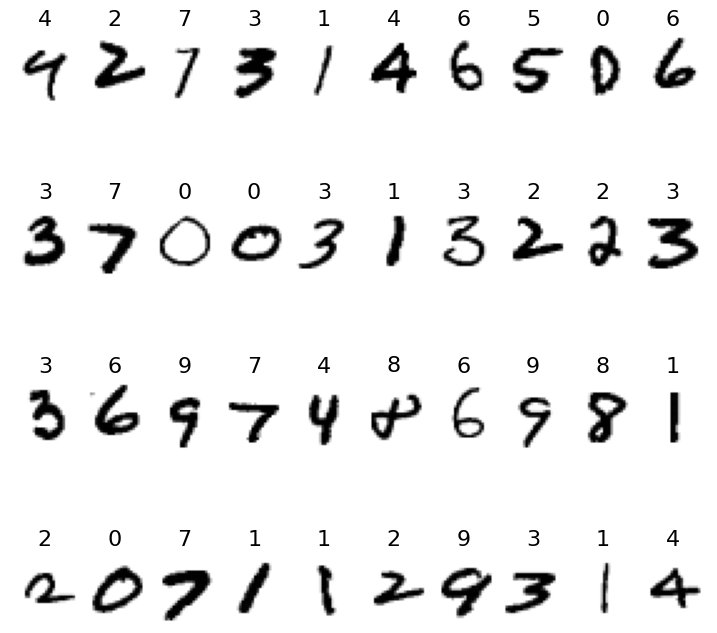

In [19]:
# Each time this cell is run, it will render 40 consecuitive random digits from the training set
i = np.random.randint(len(X_train) - 40)
plot_several_digits(X_train[i:i + 40, :], rows=4, labels=y_train[i:i + 40])

### 3.Prepare the data for machine learning algorithms

This dataset has already undergone preprocessing and is well-suited for machine learning algorithms. Nevertheless, it encompasses 10 distinct classes. To simplify our approach, we'll begin by tackling a simpler task of recognizing a single digit, such as the number 5. This simplified task is commonly referred to as **binary classification**.

In [20]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'

In [21]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421]))

### 4.Explore different models and select a suitable one

We will just use one model for now since our focus is on classification and its performance metrics.

In [22]:
# Train a stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

True Label: True
Predicted Label: True
Decision Score: 3799.8274173511372


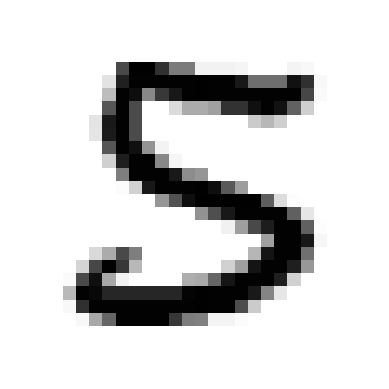

In [23]:
digit_index = 504
some_digit = X_train[digit_index].reshape(1, -1)
true_label = y_train_5[digit_index]
predicted_label = sgd_clf.predict(some_digit)[0]
decision_score = sgd_clf.decision_function(some_digit)[0]

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Decision Score: {decision_score}")
plot_digit(some_digit)

### 5.Fine-tune your model

For now, we will skip this step because our objective is to delve into classification and its performance metrics, rather than deploying the model.

## Performance Measures

Assessing the performance of a classifier presents some unique challenges compared to evaluating a regressor. Instead of comparing numerical values, we're dealing with different classes. Fortunately, a variety of performance metrics are at our disposal. In the following cells, we will delve into some of these metrics.

### Accuracy

In `sklearn`, predictors have a `score` method that offers a default evaluation criterion tailored to the problem they address.

As stated in the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) documentation, the `score(X, y[, sample_weight])` method calculates and returns the mean **accuracy** on the provided test data and labels.


In [24]:
sgd_clf.score(X_train, y_train_5)

0.9522666666666667

This score was for the training set. Of course a better evaluation will be to use cross validation.

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

scores

array([0.95035, 0.96035, 0.9604 ])

**Note:** By default, the `cross_val_score` function employs the predictor's default scoring metric. In the previous code cell, setting `scoring="accuracy"` ensures that the returned scores will be the accuracy.

In [26]:
scores.mean()

0.9570333333333334

95% accuracy, sounds good! Before we get too excited, let's train a classifier that consistently selects the most frequent class in the training set, which, in our case, is `False` or not 5. In essence, this classifier will always choose one class regardless of the input.

In [27]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [28]:
# No `True` digit 5 class will be predicted
print(any(dummy_clf.predict(X_train)))

False


In [29]:
dummy_scores = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

dummy_scores

array([0.90965, 0.90965, 0.90965])

In [30]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421]))

In [31]:
5421 / 54579

0.09932391579178805

Only 10% of the training data represents the digit 5, while the remaining 90% consists of non-digit 5 samples. Therefore, making a naive prediction that an image is not digit 5 would yield a correct prediction approximately 90% of the time.

This highlights the importance of using metrics other than accuracy when evaluating classifier performance, especially in scenarios involving imbalanced datasets, where some classes are significantly more prevalent than others.

### Confusion Matrix

**Note to self: Go through Notability first**

To create a confusion matrix, we need a set of predictions to compare against the actual targets. Ideally, these predictions should be made for instances that were not part of the training data. One approach to obtain these "out-of-sample" or "clean" predictions, without relying on the test set, is to utilize `cross_val_predict`. This function, akin to `cross_val_score`, differs in that it provides "clean" predictions for each instance in the training set rather than computing scores over K-fold cross-validation.


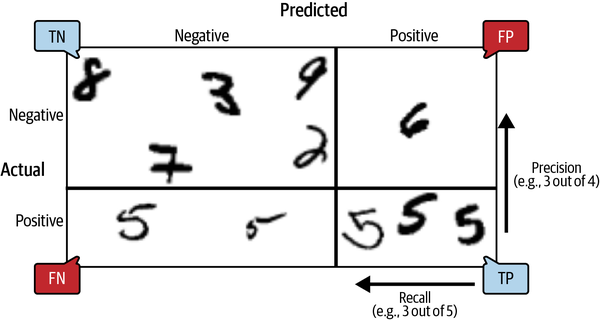

The figure above is from the handson_ml3 book (Figure 3-3)

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

In [34]:
# perfect classifier
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [35]:
TN = cm[0, 0] # True Negative
FP = cm[0, 1] # False Positive
FN = cm[1, 0] # False Negative
TP = cm[1, 1] # True Positive

In [36]:
# accuracy
a = (TP + TN) / (TN + FP + FN + TP)
a

0.9570333333333333

### Precision

Calculated solely from predicted positive instances, this metric evaluates the proportion of detections that are genuinely positive, effectively assessing the accuracy of positive predictions.

$$
\text{precision} = \frac{TP}{TP + FP}
$$

In [37]:
p = TP / (TP + FP)
p

0.8370879772350012

No need to remember the equations, `sklearn.metrics` contains many of them

In [38]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

This metric can be manipulated by training a classifier to predict only a single instance as positive (the one with the highest confidence), while classifying all others as negative:

$$
\text{precision} = \frac{1}{1 + 0} = 100\%
$$

Such a classifer is not very useful, this is why precision is usually used along with another metric called **recall**




### Recall

The ratio of the true positives correctly detected by the classifier Also called sensitivity or true positive rate (TPR)

$$
\text{recall} = \frac{TP}{TP + FN}
$$

In [39]:
r = TP / (TP + FN)
r

0.6511713705958311

In [40]:
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### Precision/Recall Trade-Off

**Note to self: Go through graphical explatnation in Notability**

Precision and recall frequently exhibit a trade-off; as one increases, the other decreases. Typically, you establish the desired value for one of them as a target percentage and then determine the nearest threshold that achieves that percentage.



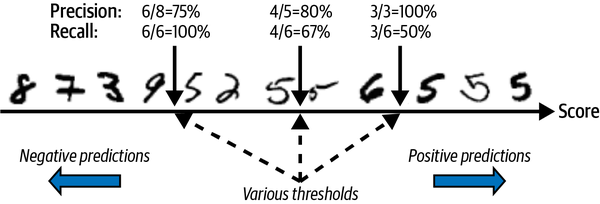

The figure above is from the handson_ml3 book (Figure 3-4)

`scikit-learn` does not provide an explicit mechanism for setting a specific threshold. Nevertheless, we can obtain the decision scores by invoking the `decision_function()` method instead of obtaining the actual predictions using `predict()`.

True Label: True
Predicted Label: True
Decision Score: 8373.510882497665


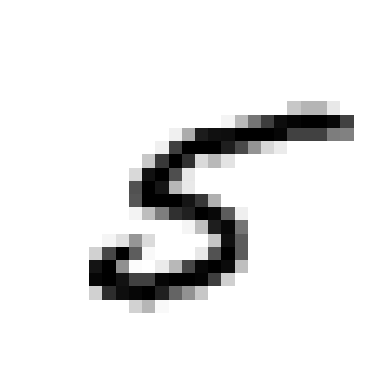

In [41]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_label = y_train_5[digit_index]
predicted_label = sgd_clf.predict(some_digit)[0]
decision_score = sgd_clf.decision_function(some_digit)[0]

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Decision Score: {decision_score}")
plot_digit(some_digit)

In [42]:
# make predictions using a threshold
threshold = 0 # default value
print(f"prediction using threshold ({threshold}):", decision_score > threshold)

prediction using threshold (0): True


In [43]:
# make predictions using a threshold
threshold = 8500 # much higher value
print(f"prediction using threshold ({threshold}):", decision_score > threshold)

prediction using threshold (8500): False


We can create a plot that shows precision and recall at various thresholds. This visual representation can assist us in determining an appropriate threshold value.

In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

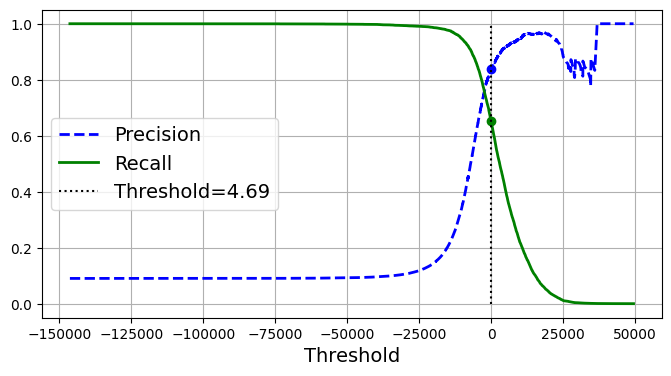

In [46]:
threshold = 0

plt.figure(figsize=(8 ,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

idx = (thresholds >= threshold).argmax() # first index >= threshold (or first True)
actual_threshold = thresholds[idx]
plt.plot(actual_threshold, precisions[idx], "bo")
plt.plot(actual_threshold, recalls[idx], "go")
plt.vlines(actual_threshold, 0, 1.0, "k", "dotted", label="Threshold={:.2f}".format(actual_threshold))
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.show()

We can also generate a plot of the recalls vs precisions

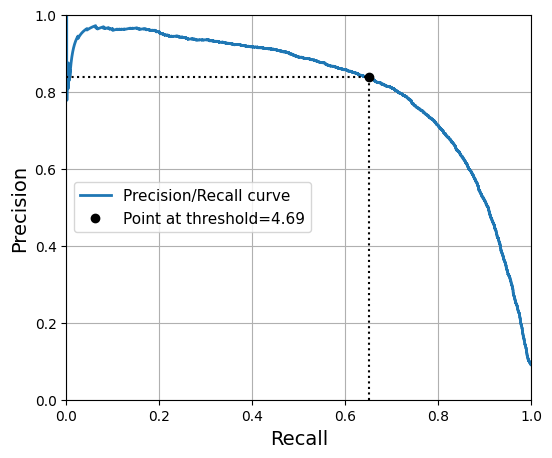

In [47]:
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)

# show the current threshold
plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], "k:")
plt.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold={:.2f}".format(actual_threshold))

plt.legend(loc="center left", fontsize=11)

plt.show()

An ideal classifier would position us at the top right of the Precision-Recall curve (Precision = 1 and Recall = 1). However, since our classifier is not ideal, we must decide whether to prioritize precision or recall and then identify the corresponding threshold.

Raising the threshold enhances precision and results in an upward shift, meaning we move counterclockwise along the Precision/Recall curve depicted above.

**Find the threshold for a specific recall**

In [48]:
needed_recall = 0.9

idx_for_needed_recall =(recalls >= needed_recall).argmin() #recalls is arranged in descending order so we use argmin
threshold = thresholds[idx_for_needed_recall]
y_threshold_predictions = y_scores >= threshold
print("threshold =", threshold)
print("precisions =", precision_score(y_train_5, y_threshold_predictions))
print("recall =", recall_score(y_train_5, y_threshold_predictions))

threshold = -6861.032537940254
precisions = 0.5160266582037448
recall = 0.8998339789706696


**Find the threshold for a specific precision**

In [49]:
needed_precision = 0.9

idx_for_needed_precision =(precisions >= needed_precision).argmax()
threshold = thresholds[idx_for_needed_precision]
y_threshold_predictions = y_scores >= threshold
print("threshold =", threshold)
print("precisions =", precision_score(y_train_5, y_threshold_predictions))
print("recall =", recall_score(y_train_5, y_threshold_predictions))

threshold = 3370.0194991439557
precisions = 0.9000345901072293
recall = 0.4799852425751706


In summary, when defining a precision target, it's essential to consider the associated recall rate. If you set a precision target, you should ask yourself at what recall?

### F-scores

It can be more convenient to consolidate precision and recall into a single metric (i.e. when comparing two classifiers or during hyperparameter tuning). For a given threshold, representing a specific point on the precision/recall curve, we can combine precision and recall into a single value:

$$
F_{\beta} = (1 + \beta^2)
    \frac{\text{precision} \times \text{recall}}
         {\beta^2 \text{precision} + \text{recall}}
$$

The value of $\beta$ can be interpreted as recall is $\beta$ more important than precision.

For example $\beta = 1$ means recall and precision have the same importance.

$$
F_1 = 2 \times
  \frac{\text{precision} \times \text{recall}}
         {\text{precision} + \text{recall}}
$$
Which is what we call the harmonic mean (as opposed to the arithmetic mean we are used to). Harmonic mean favors classifiers with higher and roughly equal precision and recall.

* $\beta = 0$ considers only precision
* $\beta \rightarrow \infty$ considers only recall
* $\beta < 1$ precision is more important than recall
* $\beta > 1$ recall is more imporant than precision

In [50]:
# show the value of F1 scores for different precision/recall combination
# the F1 score favors high and matching values of precision and recall
def my_f1score(p, r):
  if (p + r == 0):
    return 0
  else:
    return 2 * (p * r) / (p + r)

print("\t", end='')

for r in np.linspace(0, 1.0, 6):
  print("r={:.2f}".format(r),end='\t')

print()
print("-"*60)

for p in np.linspace(0, 1.0, 6):
  print("p={:.2f}|".format(p), end='\t')
  for r in np.linspace(0, 1.0, 6):
    print("  {:.2f}".format(my_f1score(p, r)), end='\t')
  print()

	r=0.00	r=0.20	r=0.40	r=0.60	r=0.80	r=1.00	
------------------------------------------------------------
p=0.00|	  0.00	  0.00	  0.00	  0.00	  0.00	  0.00	
p=0.20|	  0.00	  0.20	  0.27	  0.30	  0.32	  0.33	
p=0.40|	  0.00	  0.27	  0.40	  0.48	  0.53	  0.57	
p=0.60|	  0.00	  0.30	  0.48	  0.60	  0.69	  0.75	
p=0.80|	  0.00	  0.32	  0.53	  0.69	  0.80	  0.89	
p=1.00|	  0.00	  0.33	  0.57	  0.75	  0.89	  1.00	


In [51]:
from sklearn.metrics import fbeta_score, f1_score

print("threshold =", threshold)
print("precisions =", precision_score(y_train_5, y_threshold_predictions))
print("recall =", recall_score(y_train_5, y_threshold_predictions))

print("F1 score=", f1_score(y_train_5, y_threshold_predictions))
print("Fbeta score (Beta = 1)=", fbeta_score(y_train_5, y_threshold_predictions, beta=1))
print("Fbeta score (Beta = 0.5)=", fbeta_score(y_train_5, y_threshold_predictions, beta=0.5))
print("Fbeta score (Beta = 2)=", fbeta_score(y_train_5, y_threshold_predictions, beta=2))


threshold = 3370.0194991439557
precisions = 0.9000345901072293
recall = 0.4799852425751706
F1 score= 0.6260827718960539
Fbeta score (Beta = 1)= 0.6260827718960539
Fbeta score (Beta = 0.5)= 0.7659699735060347
Fbeta score (Beta = 2)= 0.5293997965412004


### The Receiver Operating Characteristic (ROC) Curve

Similar to the precision/recall curve. However, it plots the _False Positive Rate (FPR)_ (which is also called Fallout) against the _True Positive Rate (TPR)_ (which is another name for recall)

FPR/Fallout is the ratio of negative instances that are incorrectly classified as positive.

$$
\text{False Positive Rate} = \text{Fall-Out} =\frac{FP}{FP + TN} = \frac{FP}{N}
$$

$$
\text{True Positive Rate} = \text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$



In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

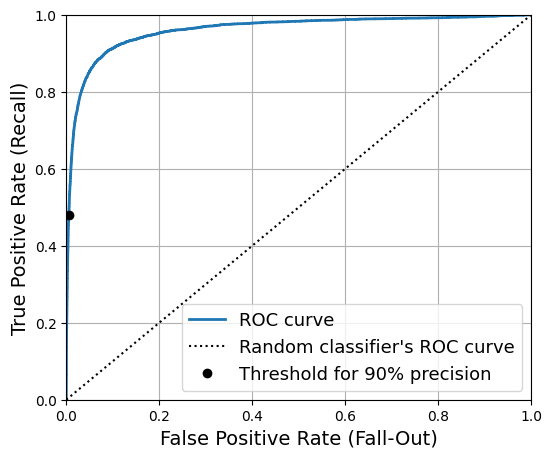

In [53]:
threshold_idx = (thresholds <= threshold).argmax()
tpr_threshold = tpr[threshold_idx]
fpr_threshold = fpr[threshold_idx]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_threshold], [tpr_threshold], 'ko', label=f"Threshold for {needed_precision:.0%} precision")

plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()


Similar to the precision/recall curve, there exists a tradeoff between the True Positive Rate and False Positive Rate. A higher True Positive Rate signifies a smaller threshold and subsequently an increase in false positives, corresponding to higher false positive rates.

The dotted line represents the ROC curve of a random classifier. A good classifier is expected to maintain a significant distance from this line towards the top-left corner.

The area under the ROC curve (AUC) is a metric that quantifies the performance of a classifier. An optimal classifier will achieve an AUC of 1, while a random classifier typically scores 0.5 on this metric.

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

The ROC curve and the precision/recall (PR) curve share similarities. Generally, it is advisable to opt for the PR curve when dealing with imbalanced datasets, rare positive classes, or when placing a higher emphasis on minimizing false positives over false negatives. In other cases, the ROC curve is more appropriate.

In the given example, while the ROC AUC suggests the classifier's overall effectiveness, it's worth noting that the number of positive instances is significantly lower than the negatives. This is why the PR curve indicates there's room for improvement, as it could potentially be shifted closer to the top right corner, reflecting an enhanced trade-off between precision and recall.

### `RandomForestClassifier` Performance

In the following code blocks, we train a `RandomForestClassifier` and compare its performance to the `SGDClassifier`

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [56]:
# This will take time
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

The Random Forest Classifier lacks a `decision_function` method due to how it functions. Nevertheless, it provides prediction probabilities, which can serve as a substitute for decision scores.

In [57]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The random forest predicts the first instance as positive with a probability of 89% and the second instance as negative with a probability of 99%. The probabilities in each row should add up to 100%.

In [58]:
# use the prediction probabilities for the positive class as scores
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

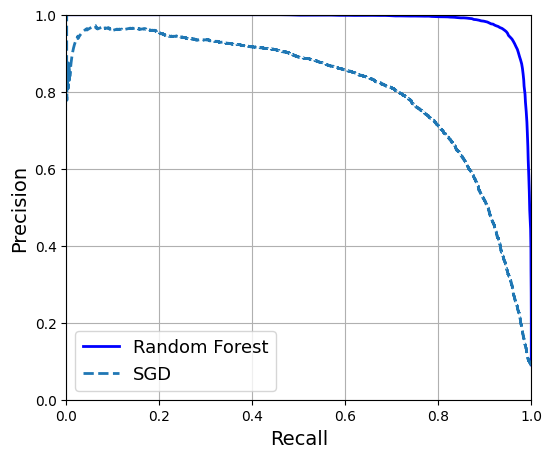

In [59]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left", fontsize=13)
plt.show()

The Random Forest looks better, let's compute the different metrics

In [60]:
# we can use corss_val_predict without a method. But we already have the probabilities
# so we can just use a default threshold of 50%

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5


In [61]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [62]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [63]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [64]:
roc_auc_score(y_train_5, y_train_pred_forest)

0.9358174809192218

In [65]:
# The perfomrance metrics for the SGD classifier
print(f"SGD Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"SGD Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"SGD F1: {f1_score(y_train_5, y_train_pred)}")
print(f"SGD ROC AUC: {roc_auc_score(y_train_5, y_scores)}")

SGD Precision: 0.8370879772350012
SGD Recall: 0.6511713705958311
SGD F1: 0.7325171197343847
SGD ROC AUC: 0.9604938554008616


## Multiclass (Multinomial) Classification

Binary classifiers discriminate between two classes, while multiclass classifiers can differentiate between more than two classes. It's important to clarify that a given input can belong to only one class.

The original MNIST problem serves as an example of a multiclass classifier. It involves recognizing digits that can belong to any of the ten classes, representing numbers from 0 to 9.

Certain classifiers, like Logistic Regression, Random Forest, and Gaussian Naive Bayes, inherently support multinomial classification. However, there are classifiers that are inherently binary in nature, such as Support Vector Machine classifiers and SGD classifiers, designed primarily for binary classification tasks.

There are strategies for using binary classifiers in multiclass problems:

1. **One-versus-the-Rest (OvR)** also known as **One-versus-All (OvA)**<br>
Train individual binary classifiers for each class, amounting to a total of $N$ classifiers. For instance, in the case of the MNIST problem with $N=10$ classes, you would train 10 binary classifiers:

  * 0 vs not 0
  * 1 vs not 1
  * 2 vs not 2
  * ...
  * 9 vs not 9 <br><br>
When making a new prediction, obtain the decision scores from each of the classifiers and choose the class associated with the classifier with the highest score.

2. **One-versus-One (OvO)**: <br> Train binary classifiers for every possible pair of classes, totaling $N(N - 1)/2$ classifiers. In the case of the MNIST problem with $N=10$ classes, this would entail training $10(10-1)/2 = 45$ classifiers:
  * 0 vs 1
  * 0 vs 2
  * 0 vs 3
  * ...
  * 8 vs 9
  <br><br>
When making predictions for a new instance, it is presented to all the trained classifiers. The class that emerges victorious in the majority of the duels between the classifiers is considered the final prediction.

In OvO (One-vs-One) classification, each classifier is trained on a subset of the training set. This approach is advantageous when dealing with algorithms that do not scale well with large training sets (i.e. Support Vector Machines). It involves training many classifiers on smaller subsets rather than training fewer classifiers on larger datasets. However, for the majority of classification problems, the OvR (One-vs-Rest) strategy is the preferred choice.

When `sklearn` identifies a multiclass classification task employing a binary classifier, it automatically defaults to either OvR or OvO, depending on the chosen classification algorithm. Nevertheless, you can explicitly specify and enforce either of the approachs.

Support vector machines are known for their limited scalability with larger datasets. To expedite the execution of the following code blocks and for the sole purpose of illustration, we can utilize the first 2000 instances of the training set, thus training on a considerably smaller dataset.

In [66]:
# Training using the first 2000 instances only
# Run this in class

from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train contains 10 classes

SVC(random_state=42)

When a classifier is trained (or “fitted”), it stores the list of target classes in its `classes_` attribute, ordered by value. For MNIST, the class labels coincidentally matched the indices.

In [67]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [68]:
# This cell will take some time to run (about 6 min)
# Do not run this in class

from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train) # y_train contains 10 classes

SVC(random_state=42)

True Label: 5
Predicted Label: 5
Decision Score: [ 6.10062259  2.7348705   4.91079719  6.00341393  2.79291037  9.31686672
  3.80826005  0.70473155  8.26497034 -0.29845642]


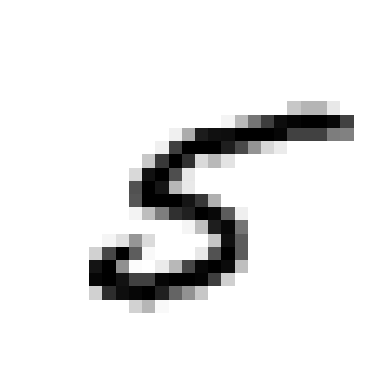

In [69]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_label = y_train[digit_index]
predicted_label = svm_clf.predict(some_digit)[0]
decision_score = svm_clf.decision_function(some_digit)[0]

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Decision Score: {decision_score}")
plot_digit(some_digit)

In [70]:
svm_clf.decision_function_shape

'ovr'

The `decision_function` method returned 10 scores, and the predicted class corresponds to the one with the highest score.

The `SVC` classifier is designed as a binary classifier and employs the One-vs-One (OvO) strategy to handle multiclass problems. In the previous example, there were 45 predictions, one for each pair of classes, and the predicted class is the one that emerged victorious in most pairwise comparisons. However, the `decision_function` returned only 10 scores because the `decision_function_shape` was set to `ovr` (One-vs-Rest). To obtain all 45 scores, you should set it to `ovo` (One-vs-One).

Please note that the `decision_function_shape` parameter controls the reported shape only and does not change the underlying classification strategy. In other words, the `SVC` classifier still employs the One-vs-One (OvO) strategy, even if its shape is set to 'OvR' (One-vs-Rest). The 'OvR' setting aggregates the 45 scores into 10.

In [71]:
svm_clf.decision_function_shape = 'ovo'

True Label: 5
Predicted Label: 5
Decision Score: [ 0.17154279 -0.20550491  0.1186313   0.58291687 -1.82784464  0.08894267
  0.66510045 -0.06820131  0.90681018  0.14520105 -0.61316593 -0.43297446
 -2.15517896 -0.34764795  0.4076499  -1.10033547  0.38068373 -0.0843387
  0.12102147 -1.89029857  0.22519376  1.01991712 -0.73491666  0.91772787
  0.03363314 -2.24832099  0.21750713  0.85242262 -0.12143381  0.69766635
 -2.27225588 -0.17413817  0.52394811 -0.79710188  1.38374911  2.03218767
  2.38835474  2.0295632   2.39897553  0.66558592 -0.45187542  0.47417563
 -1.25669634  0.02269689  1.37493435]


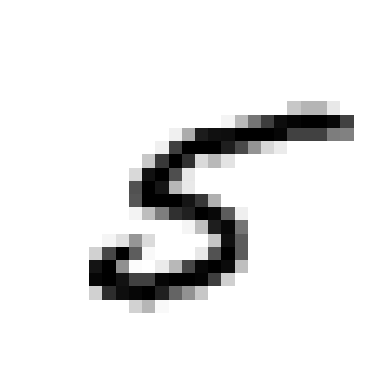

In [72]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_label = y_train[digit_index]
predicted_label = svm_clf.predict(some_digit)[0]
decision_score = svm_clf.decision_function(some_digit)[0]

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Decision Score: {decision_score}")
plot_digit(some_digit)

You can instruct scikit-learn to employ either the One-vs-One (OvO) or One-vs-Rest (OvR) strategy with any classifier by utilizing the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance of the desired class and pass the classifier as an argument to its constructor (not necessarily a binary classifer).

In [73]:
# Training using the first 2000 instances only
# Run this in class

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [74]:
# This cell will take some time to run (about 35 min)
# Do not run this in class

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

True Label: 5
Predicted Label: 5
Decision Score: [-1.62094997 -2.5719663  -1.79052196 -2.23449663 -2.42299487  2.17644425
 -1.71779249 -2.71807152 -1.7401107  -3.26930886]


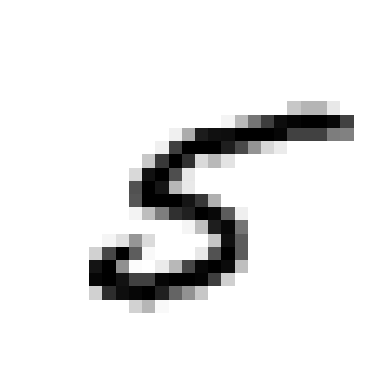

In [75]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_label = y_train[digit_index]
predicted_label = ovr_clf.predict(some_digit)[0]
decision_score = ovr_clf.decision_function(some_digit)[0]

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Decision Score: {decision_score}")
plot_digit(some_digit)

## Error Analysis

To understand the classifier's errors, we'll examine both the confusion matrix and the instances that were incorrectly classified.

In [76]:
# This cell will take some time to run (about 5 min)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

This confusion matrix contains numerous numbers that can be challenging to interpret. Using a visual diagram to represent it would enhance readability and facilitate analysis.

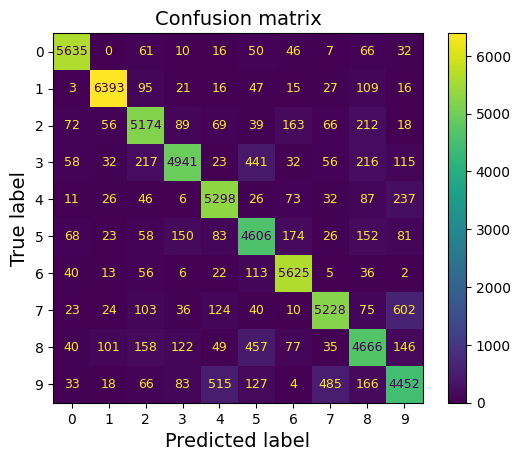

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title('Confusion matrix')
plt.show()

Looks promising, with the majority of images falling on the main diagonal, signifying correct classifications. Notably, the darkest diagonal cells correspond to '5,' '8,' and '9.' This could be attributed to fewer samples for these classes or a higher rate of misclassifications by the classifier. To mitigate the impact of instance counts, we can normalize the confusion matrix by dividing all cells by the row sum (number of true labels), thus providing a clearer view of error rates.

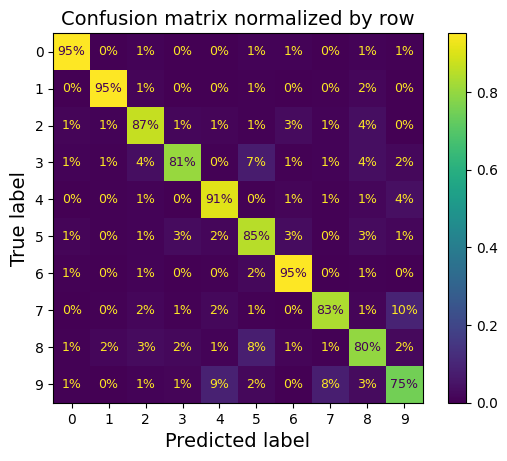

In [78]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize='true', values_format='.0%')

# values_format = '.0%' shows percentages with no decimals

plt.title('Confusion matrix normalized by row')
plt.show()

It's evident that '9' emerges as the most frequently misclassified class. Around 10% of '7' instances were misclassified as '9,' and approximately 8% of '9' instances were erroneously classified as '7'.It's important to note that the confusion matrix doesn't have to be symmetrical.

To accentuate the errors, we can assign zero weight to the accurate predictions, effectively emphasizing the misclassifications.

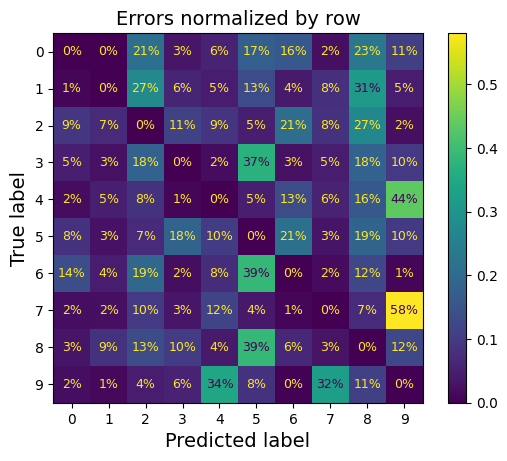

In [79]:
sample_weight = (y_train != y_train_pred)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize='true', values_format='.0%',
                                        sample_weight=sample_weight)
plt.title('Errors normalized by row')
plt.show()

The most prevalent error appears to be '7' being misclassified as '9.' It's crucial to emphasize that these numbers exclusively represent errors. For instance, about 58% of the errors associated with the true label '7' were '7' being mistaken for '9,' in reality only 10% of all '7' instances were misclassified as '9'.

The diagram also highlights that a common misclassification occurs with class '8.' The model tends to misclassify multiple instances as '8.'

Now, let's examine a selection of the misclassified digits.

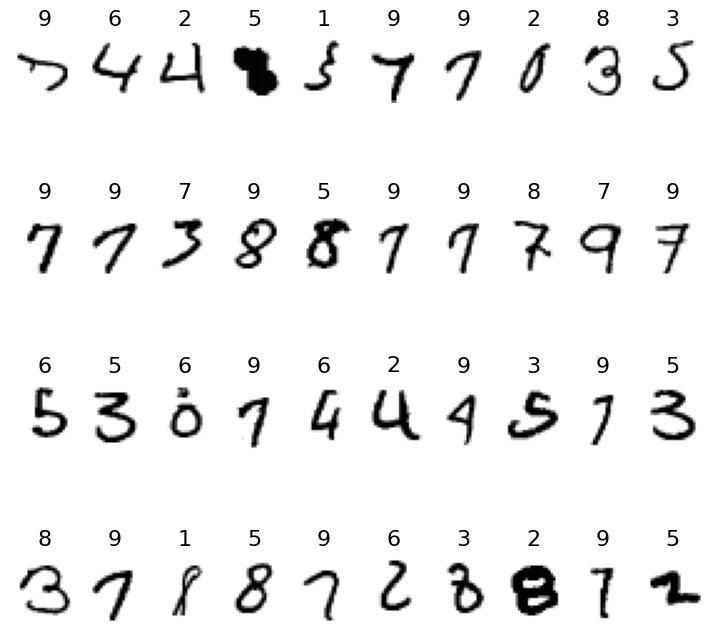

In [80]:
# This cell displays 40 misclassified digits each time it's run.

misclassified_idx = y_train != y_train_pred
misclassified_X_train = X_train[misclassified_idx]
misclassified_y_train = y_train[misclassified_idx]
misclassified_y_train_pred = y_train_pred[misclassified_idx]

i = np.random.randint(len(misclassified_X_train) - 40)
plot_several_digits(misclassified_X_train[i:i + 40, :], rows=4, labels=misclassified_y_train_pred[i:i + 40])

Let's look at instances of a spcific digit.

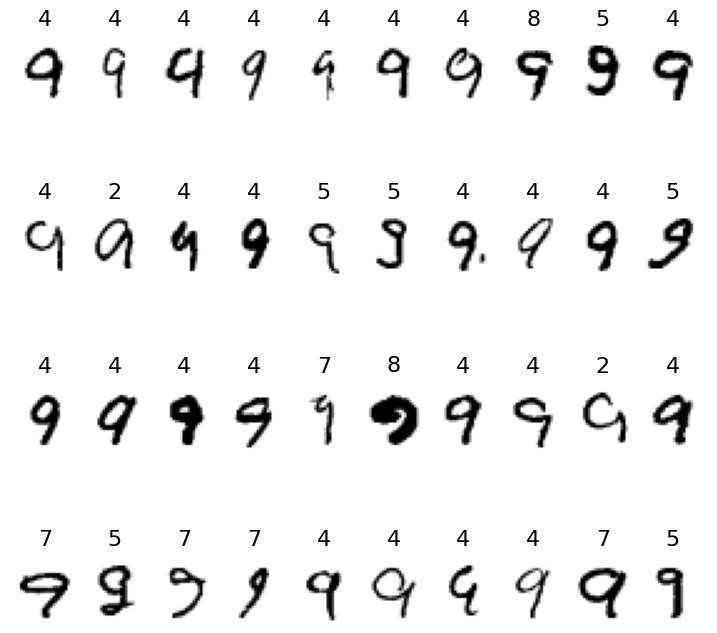

Examples of misclassified 9


In [81]:
# This cell displays 40 misclassified specific digits each time it's run.

digit = '9'
#digit = '7'
#digit = '8'

misclassified_idx_digit = (y_train != y_train_pred) & (y_train == digit)
misclassified_X_train_digit = X_train[misclassified_idx_digit]
misclassified_y_train_digit = y_train[misclassified_idx_digit]
misclassified_y_train_pred_digit = y_train_pred[misclassified_idx_digit]

i = np.random.randint(len(misclassified_X_train_digit) - 40)
plot_several_digits(misclassified_X_train_digit[i:i + 40, :], rows=4, labels=misclassified_y_train_pred_digit[i:i + 40])
plt.show()

print(f"Examples of misclassified {digit}")

## Multilabel Classification

So far, we have discussed problems that predicts a single (binary or multinomial) class for each input instance. However, there are situations in which each input instance can be associated with multiple binary classes. In the MNIST example mentioned earlier, we can, for instance, predict whether an input image represents a large number (i.e., greater than or equal to 7) and determine whether the image corresponds to an odd number. The following code cells illustrate this example.


In [82]:
from sklearn.neighbors import KNeighborsClassifier

# Generate 2 labels for each instance in the training set
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# KNeighborsClassifier natively supports multilabel classifications
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

True Labels: [False  True]
Predicted Labels: [False  True]


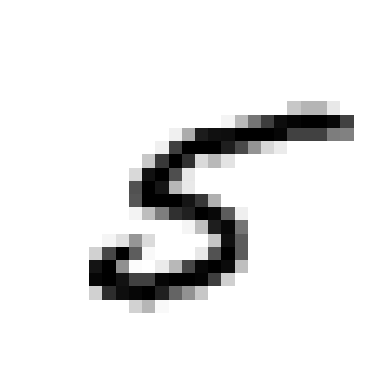

In [83]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_labels = y_multilabel[digit_index]
predicted_labels = knn_clf.predict(some_digit)[0]

print(f"True Labels: {true_labels}")
print(f"Predicted Labels: {predicted_labels}")
plot_digit(some_digit)

We can utilize any of the performance metrics we covered above to evaluate the effectiveness of the multilabel classifier. It's important to note that each label will produce its individual score, and we need to combine these results by calculating an aggregate score, such as averaging the scores for all labels.

In [84]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

Certain classifiers do not inherently accommodate multilabel classification. In such instances, we can employ a cascaded chain of classifiers, where each classifier considers the predictions of the preceding one, in addition to the input features, when making its own prediction.

While it is possible to employ independent classifiers for each label, this approach might overlook potential interactions between the labels. In other words, independent classifiers are unable to discern label interactions unless they are integrated into a cascaded system and have access to the predictions from earlier stages.

In [85]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000]) # use 2000 images only to speed things up

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

True Labels: [False  True]
Predicted Labels: [0. 1.]


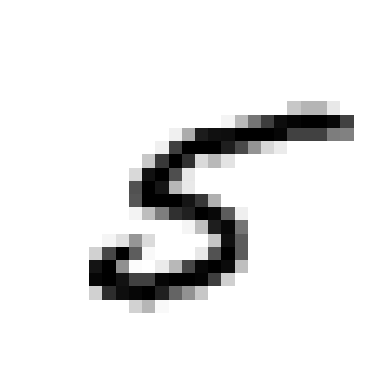

In [86]:
digit_index = 513
some_digit = X_train[digit_index].reshape(1, -1)
true_labels = y_multilabel[digit_index]
predicted_labels = chain_clf.predict(some_digit)[0]

print(f"True Labels: {true_labels}")
print(f"Predicted Labels: {predicted_labels}")
plot_digit(some_digit)

--------
# Exercises


## 1. MNIST using `KNeighborsClassifier`

In the previous code cells, we primarily utilized `SGDClassifier` and `SVC`, both of which are linear models, and we also explored `RandomForestClassifier`, a non-linear model. Now, let's repeat the analysis using the `KNeighborsClassifier`. Here's the plan:

1. Begin by reading the `KNeighborsClassifier` documentation to gain insight into its hyperparameters.
2. Fit the model with its default hyperparameter values.
3. Conduct a fine-tuning phase using `GridSearchCV` to optimize the hyperparameters.
4. Perform an error analysis, which includes generating visual representations like the confusion matrix and examples of misclassified instances.
5. Report the precision, recall, F1 score, and accuracy on the test set `X_test` and `y_test`